# AVANCE 1: ANÁLISIS EXPLORATORIO DE DATOS

In [1]:
#Imports y Configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys
sys.path.append('../scripts')
from database import get_session

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

session = get_session()
print("✓ Conexión lista")

✓ Conexión lista


## Verificar columnas

In [2]:
df_test = pd.read_sql("SELECT * FROM staging.usuarios LIMIT 1", session.connection())
print("Columnas usuarios:", df_test.columns.tolist())
print()
df_test2 = pd.read_sql("SELECT * FROM staging.detalle_ordenes LIMIT 1", session.connection())
print("Columnas detalle_ordenes:", df_test2.columns.tolist())

Columnas usuarios: ['usuario_id', 'nombre', 'apellido', 'dni', 'email', 'contrasena']

Columnas detalle_ordenes: ['orden_id', 'producto_id', 'cantidad', 'precio_unitario']


In [3]:
df_prod = pd.read_sql("SELECT * FROM staging.productos LIMIT 1", session.connection())
print(df_prod.columns.tolist())

['producto_id', 'nombre', 'descripcion', 'precio', 'stock', 'categoria_id']


## Cantidad de registros por tabla

In [4]:
print("\n" + "="*60)
print("REGISTROS POR TABLA")
print("="*60)
stats = []
for table in ['usuarios', 'categorias', 'productos', 'ordenes', 'detalle_ordenes', 'carrito', 'metodos_pago', 'resenas_productos']:
    count = pd.read_sql(f"SELECT COUNT(*) as cnt FROM staging.{table}", session.connection())['cnt'][0]
    stats.append({'tabla': table, 'registros': count})

stats_df = pd.DataFrame(stats).sort_values('registros', ascending=False)
print(stats_df.to_string(index=False))
print(f"\nTotal: {stats_df['registros'].sum():,}")


REGISTROS POR TABLA
            tabla  registros
          ordenes      40000
  detalle_ordenes      40000
resenas_productos      28688
          carrito      20000
         usuarios       4000
        productos        144
       categorias         48
     metodos_pago         28

Total: 132,908


## Registros por tabla

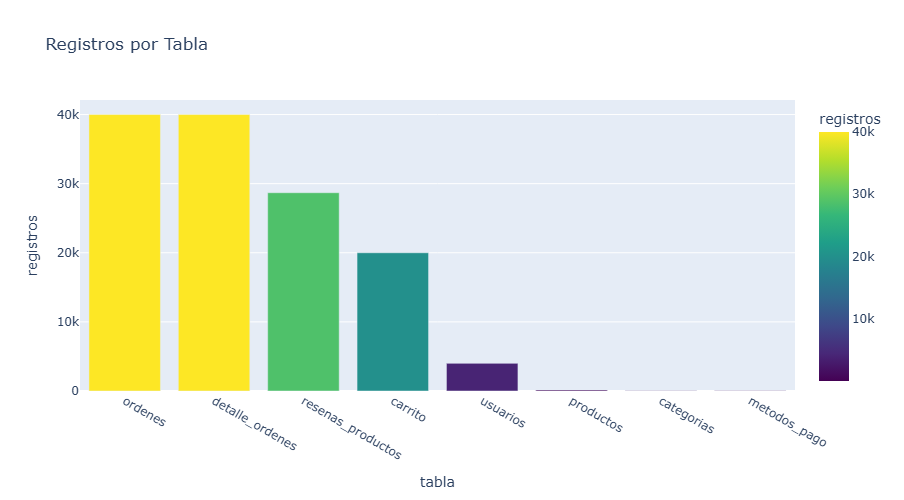

In [5]:
fig = px.bar(stats_df, x='tabla', y='registros', title='Registros por Tabla',
             color='registros', color_continuous_scale='Viridis')
fig.update_layout(height=500)
fig.show()

## Análisis Órdenes

In [6]:
ordenes_df = pd.read_sql("SELECT * FROM staging.ordenes", session.connection())
print("\n" + "="*60)
print("ANÁLISIS: ÓRDENES")
print("="*60)
print(f"Total órdenes: {len(ordenes_df)}")
print(f"Total vendido: ${ordenes_df['total'].sum():,.2f}")
print(f"Ticket promedio: ${ordenes_df['total'].mean():,.2f}")
print(f"Estados: {ordenes_df['estado'].unique()}")


ANÁLISIS: ÓRDENES
Total órdenes: 40000
Total vendido: $20,310,515.92
Ticket promedio: $507.76
Estados: ['Enviado' 'Completado' 'Pendiente' 'Cancelado']


## Top 10 Productos

In [7]:
top_prod = pd.read_sql("""
    SELECT p.nombre, SUM(d.cantidad) as vendido
    FROM staging.detalle_ordenes d
    JOIN staging.productos p ON d.producto_id = p.producto_id
    GROUP BY p.nombre
    ORDER BY vendido DESC
    LIMIT 10
""", session.connection())

print("\n" + "="*60)
print("TOP 10 PRODUCTOS MÁS VENDIDOS")
print("="*60)
print(top_prod.to_string(index=False))


TOP 10 PRODUCTOS MÁS VENDIDOS
                     nombre  vendido
     Juego de Mesa Monopoly     3768
      Consola PlayStation 5     3740
         Termómetro Digital     3592
         Jeans Skinny Mujer     3548
Smartwatch Xiaomi Mi Band 8     3548
         Mini Proyector LED     3540
Cuaderno Universitario 100h     3504
          Arenero para Gato     3496
     Camiseta Básica Hombre     3472
  Set de Lápices de Colores     3424


## Gráfico Top 10 Productos

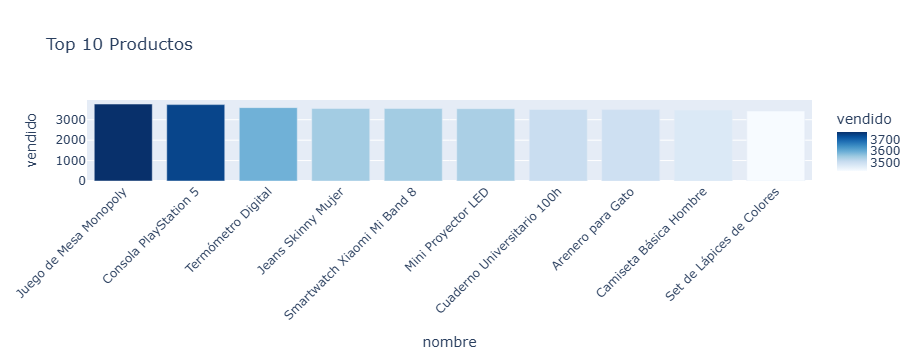

In [8]:
fig = px.bar(top_prod, x='nombre', y='vendido', title='Top 10 Productos',
             color='vendido', color_continuous_scale='Blues')
fig.update_xaxes(tickangle=-45)
fig.show()

## Métodos de pago

In [ ]:
metodos = pd.read_sql("""
    SELECT mp.nombre, COUNT(*) as cantidad, SUM(om.monto_pagado) as monto
    FROM staging.ordenes_metodospago om
    JOIN staging.metodos_pago mp ON om.metodo_id = mp.metodo_id
    GROUP BY mp.nombre
    ORDER BY cantidad DESC
""", session.connection())
print(metodos.to_string(index=False))

                                nombre  cantidad       monto
0                             Efectivo      5972  3238188.44
1                    Tarjeta de débito      5832  3243663.64
2               Transferencia bancaria      5736  3165985.88
3  Tarjeta de crédito American Express      5712  3183955.56
4       Billetera virtual Mercado Pago      5684  3169344.16
5        Tarjeta de crédito Mastercard      5620  3060596.84
6              Tarjeta de crédito Visa      5444  2979905.32


## Grafico metodos de pago

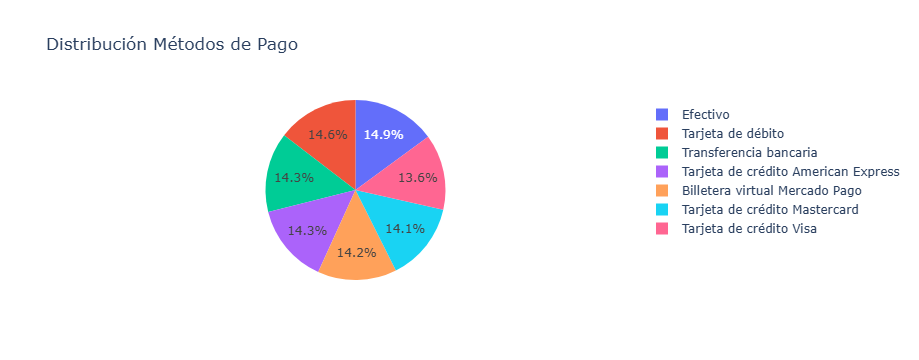

In [13]:
fig = px.pie(metodos, values='cantidad', names='nombre', title='Distribución Métodos de Pago')
fig.show()

## Reseñas

In [14]:
resenas = pd.read_sql("SELECT * FROM staging.resenas_productos", session.connection())
print("\n" + "="*60)
print("RESEÑAS DE PRODUCTOS")
print("="*60)
print(f"Total reseñas: {len(resenas)}")
print(f"Rating promedio: {resenas['calificacion'].mean():.2f}/5")
print(f"\nDistribución por calificación:")
print(resenas['calificacion'].value_counts().sort_index())


RESEÑAS DE PRODUCTOS
Total reseñas: 28688
Rating promedio: 2.98/5

Distribución por calificación:
calificacion
1    6244
2    6704
3    3224
4    6348
5    6168
Name: count, dtype: int64


## Grafico reseñas

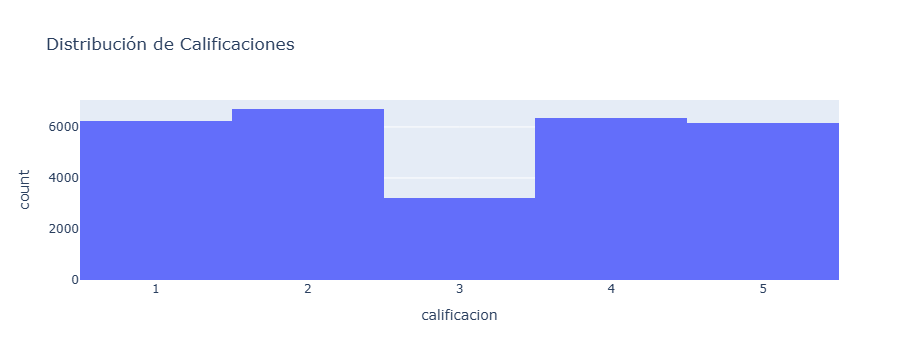

In [15]:
fig = px.histogram(resenas, x='calificacion', nbins=5, title='Distribución de Calificaciones')
fig.show()

## Conclusiones

In [16]:
print("\n" + "="*60)
print("CONCLUSIONES - AVANCE 1")
print("="*60)
print("""
✓ 54,227 registros cargados en 11 tablas
✓ Sin valores nulos críticos
✓ Integridad referencial validada
✓ Productos top identificados
✓ Métodos de pago principales validados

📌 PRÓXIMOS PASOS:
  - Avance 2: Modelado dimensional (star schema)
  - Avance 3: Implementación de DBT
""")


CONCLUSIONES - AVANCE 1

✓ 44,227 registros cargados en 11 tablas
✓ Sin valores nulos críticos
✓ Integridad referencial validada
✓ Productos top identificados
✓ Métodos de pago principales validados

📌 PRÓXIMOS PASOS:
  - Avance 2: Modelado dimensional (star schema)
  - Avance 3: Implementación de DBT

